## Exercise-6: Regularized logistic regression

In this part of the exercise, you will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.

Suppose you are the product manager of the factory and you have the
test results for some microchips on two different tests. From these two tests,you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.



In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

Data = np.loadtxt('./Files/ex2data2.txt',delimiter=",")

X = Data[:,0:2]
y = (Data[:,2]).reshape(118,1)

m = y.size
n =X.shape[1]

#### Visualizing the data

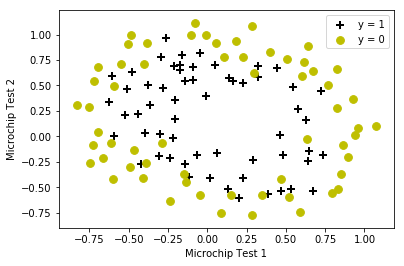

In [5]:
def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    # Get indexes for class 0 and class 1
    neg = data[:,2] == 0
    pos = data[:,2] == 1
    
    # If no specific axes object has been passed, get the current axes.
    if axes == None:
        axes = plt.gca()
    axes.scatter(data[pos][:,0], data[pos][:,1], marker='+', c='k', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg][:,0], data[neg][:,1], c='y', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True);
plotData(Data, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')

A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.

While the feature mapping allows us to build a more expressive classifier,it also more susceptible to overfitting.

&#920;<sup>T</sup>X = 1 + x<sub>1</sub> + x<sub>2</sub> + x<sub>1</sub><sup>2</sup>+ x<sub>1</sub>x<sub>2</sub> + x<sub>2</sub><sup>2</sup> + x<sub>1</sub><sup>3</sup>+ .... + x<sub>1</sub>x<sub>2</sub><sup>5</sup> + x<sub>2</sub><sup>6</sup>

h<sub>&#920;</sub>(x) = 1/(1+e<sup>-&#920;<sup>T</sup>X</sup>)

In [6]:
poly = PolynomialFeatures(6)
XX = poly.fit_transform(X)
XX.shape

(118, 28)

In [7]:
def SigmoidFn(Z):
    G = scipy.special.expit(Z)
    return G

In [8]:
# *args in function definition is used to pass a variable number of arguments to a function
def CostFnReg(Theta,reg,*args):
    h = SigmoidFn(np.dot(XX,Theta))
    J = -1*(1/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y)) + (reg/(2*m))*np.sum(np.square(Theta[1:]))
    return J[0]

In [9]:
def Gradient(Theta,reg,*args):
    h = SigmoidFn(XX.dot(Theta.reshape(-1,1)))
      
    grad = (1/m)*XX.T.dot(h-y) + (reg/m)*np.r_[[[0]],Theta[1:].reshape(-1,1)]
        
    return(grad.flatten())

In [10]:
initial_theta = np.zeros(XX.shape[1])
CostFnReg(initial_theta, 1, XX, y)

0.6931471805599454

In [11]:
def predict(theta, X, threshold=0.5):
    p = SigmoidFn(X.dot(theta.T)) >= threshold
    return(p.astype('int'))

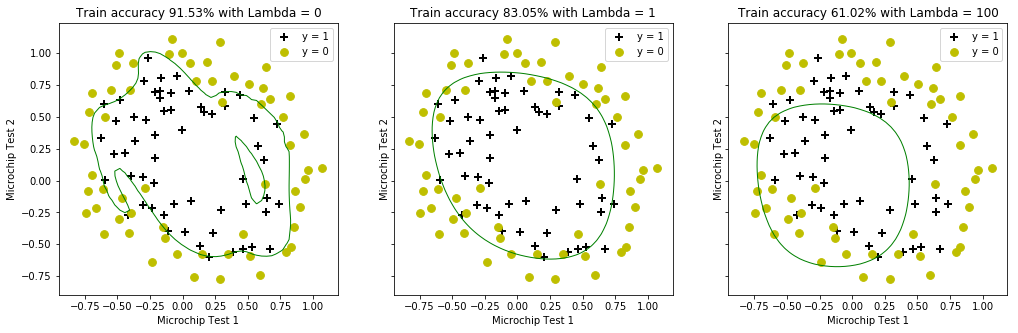

In [12]:
fig, axes = plt.subplots(1,3, sharey = True, figsize=(17,5))

# Decision boundaries
# Lambda = 0 : No regularization --> too flexible, overfitting the training data
# Lambda = 1 : Looks about right
# Lambda = 100 : Too much regularization --> high bias

for i, C in enumerate([0, 1, 100]):
    # Optimize costFunctionReg
    res2 = minimize(CostFnReg, initial_theta, args=(C, XX, y), method=None, jac=Gradient, options={'maxiter':3000})
    
    # Accuracy
    accuracy = 100*sum(predict(res2.x, XX) == y.ravel())/y.size    

    # Scatter plot of X,y
    plotData(Data, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0', axes.flatten()[i])
    
    # Plot decisionboundary
    x1_min, x1_max = X[:,0].min(), X[:,0].max(),
    x2_min, x2_max = X[:,1].min(), X[:,1].max(),
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    h = SigmoidFn(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(res2.x))
    h = h.reshape(xx1.shape)
    axes.flatten()[i].contour(xx1, xx2, h, [0.5], linewidths=1, colors='g');       
    axes.flatten()[i].set_title('Train accuracy {}% with Lambda = {}'.format(np.round(accuracy, decimals=2), C))